In [3]:
import numpy as np 
import pandas as pd 
import pandas.testing as tm
import sklearn as sl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

sns.set_style("whitegrid")
%matplotlib inline

In [5]:
#reading and preprocessing datasets
url = 'https://raw.githubusercontent.com/alrocks29/Heart-Disease-Prediction/master/heart.csv'
full_data = pd.read_csv(url)
num_features = ['age','trestbps','chol','restecg','thalach','oldpeak']
cat_features = ['sex','cp','fbs','exang','ca','thal','slope','restecg']
full_data = full_data[['sex','cp','fbs','exang','slope','restecg','ca','thal','age','trestbps','chol','thalach','oldpeak','target']]
print(f'Column names : {list(full_data.columns)}')
imp = SimpleImputer(missing_values=np.NaN)
full_data = pd.DataFrame(imp.fit_transform(full_data), columns=full_data.columns)
full_data.head()



Column names : ['sex', 'cp', 'fbs', 'exang', 'slope', 'restecg', 'ca', 'thal', 'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']


,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak,target
0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,52.0,125.0,212.0,168.0,1.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,53.0,140.0,203.0,155.0,3.1,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,70.0,145.0,174.0,125.0,2.6,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,61.0,148.0,203.0,161.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,3.0,2.0,62.0,138.0,294.0,106.0,1.9,0.0


##Data Preprocessing

We begin by removing NaN elements from the dataset and splitting into training and test sets. 
Numerical features will be scaled using StandardScaler and catagorical features will be transformed using a One-Hot Encoder, before applying a Principle Component Analysis (PCA). 

In [6]:
full_data = full_data.dropna()
cat_column_tran = ColumnTransformer([('ohe',OneHotEncoder(sparse=False), slice(0,8,1))], remainder='passthrough')
num_column_tran = ColumnTransformer([('ss',StandardScaler(),slice(9,13,1))], remainder='passthrough')
preprocess = Pipeline([('Cat_tran',cat_column_tran),('Num_tran',num_column_tran),('PCA',PCA(0.95))])

y = full_data['target']
X = full_data.drop('target', axis = 1)



### **Exploratory analysis of data**

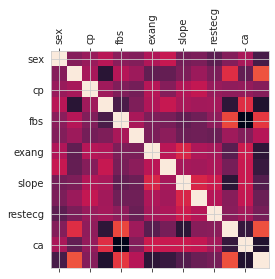

In [7]:
#plotting correlation matrix
fig = plt.figure()
ax = fig.add_subplot()
ax.matshow(full_data.corr())
ax.set_xticklabels([' ']+list(full_data.columns), rotation=90)
ax.set_yticklabels([' ']+list(full_data.columns))
plt.show()



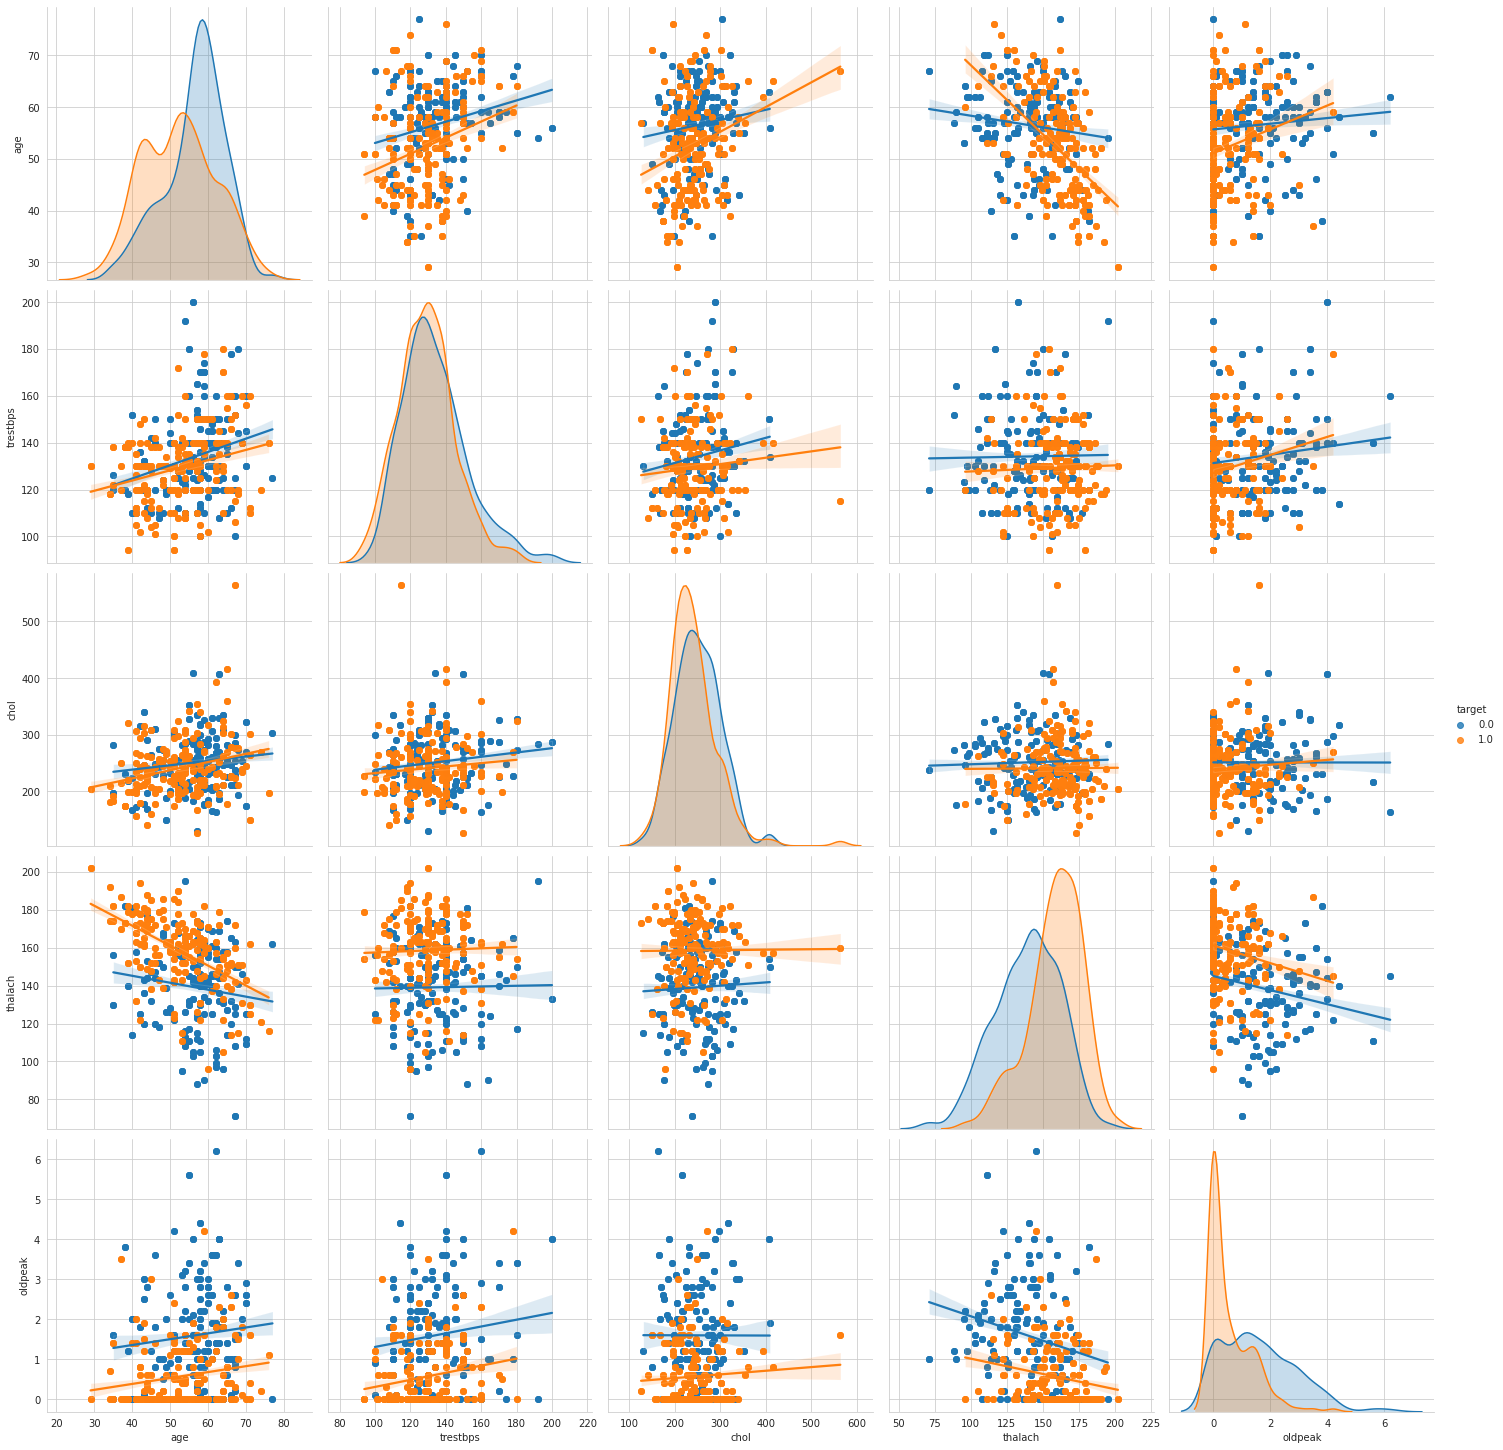

In [8]:
MF_pairplot = sns.pairplot(full_data[['age','trestbps','chol','thalach','oldpeak','target']], hue='target', kind ='reg', height = 4)
MF_pairplot

There is a lot of overlap between the classes for many of the numerical features, suggesting that the use of non-linear classification algorithms such as k-Nearest Neighbours, Decision Trees and Random Forests would be more suitable for performing classification. 

## Model Training


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state =42) 

processed_data = preprocess.fit_transform(X_train)


print(y_train.shape)
print(y_test.shape)

(717,)
(308,)


### k-Nearest Neighbours 

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
KNN = KNeighborsClassifier()

Performing a grid search to obtain the best value for k:

In [11]:
from sklearn.model_selection import GridSearchCV
params_KNN = dict(n_neighbors = range(1,10))
grid_search_KNN = GridSearchCV(KNN, param_grid = params_KNN, cv =4, scoring='recall')
grid_search_KNN.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

For a k-Nearest Neighbors model, the optimal value of k is 1


Text(0, 0.5, 'Mean recall over 4 cross-validation sets')

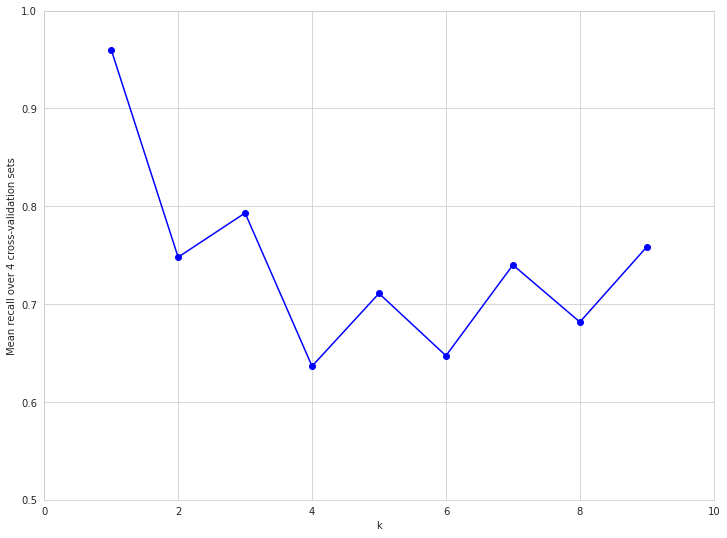

In [12]:
KNN_best_k = grid_search_KNN.best_params_['n_neighbors']
print("For a k-Nearest Neighbors model, the optimal value of k is "+str(KNN_best_k))
KNN_df = pd.DataFrame(grid_search_KNN.cv_results_)
fig_KNN = plt.figure(figsize=(12,9))
plt.plot(KNN_df['param_n_neighbors'],KNN_df['mean_test_score'],'b-o')
plt.xlim(0,10)
plt.ylim(0.5,1.0)
plt.xlabel('k')
plt.ylabel('Mean recall over 4 cross-validation sets')

### K-Means Clustering

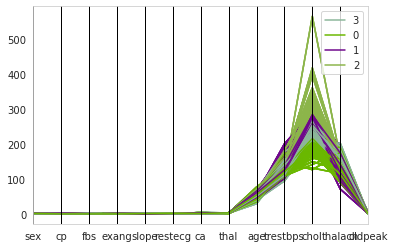

In [13]:


kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X)
predict = kmeans.predict(X)
X['cluster'] = predict
pd.plotting.parallel_coordinates(X, 'cluster')



### Decision Tree

The grid search is used to find the optimal number of layers, with maximum number of features at each node set to 1 to prevent overfitting. 

In [14]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_features = 1)

In [15]:
params_DT = dict(max_depth = range(2,30))
grid_search_DT = GridSearchCV(DT, param_grid = params_DT, cv = 4, scoring='recall')
grid_search_DT.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_features=1),
             param_grid={'max_depth': range(2, 30)}, scoring='recall')

For a Decision Tree model, the optimal number of layers is 29


Text(0, 0.5, 'Mean recall over 4 cross-validation sets')

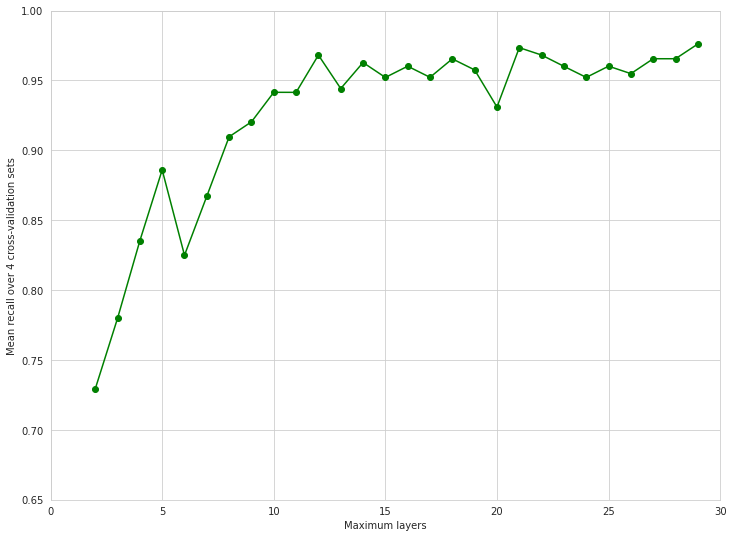

In [16]:
DT_best_layers = grid_search_DT.best_params_['max_depth']
print("For a Decision Tree model, the optimal number of layers is "+str(DT_best_layers))
DT_df = pd.DataFrame(grid_search_DT.cv_results_)
fig = plt.figure(figsize=(12,9))
plt.plot(DT_df['param_max_depth'],DT_df['mean_test_score'],'g-o')
plt.xlim(0,30)
plt.ylim(0.65,1.0)
plt.xlabel('Maximum layers')
plt.ylabel('Mean recall over 4 cross-validation sets')

### Random Forest

We use the best number of layers from the single Decision Tree model to train the forest, using a grid search to find the optimal number of trees in the forest. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth = DT_best_layers, max_features = 1)

In [18]:
params_RF = dict(n_estimators = range(1,50))
grid_search_RF = GridSearchCV(RF, param_grid = params_RF, cv = 4, scoring='recall')
grid_search_RF.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=29, max_features=1),
             param_grid={'n_estimators': range(1, 50)}, scoring='recall')

For a Random Forest, the optimal number of estimators is 11


Text(0, 0.5, 'Mean recall over 4 cross-validation sets')

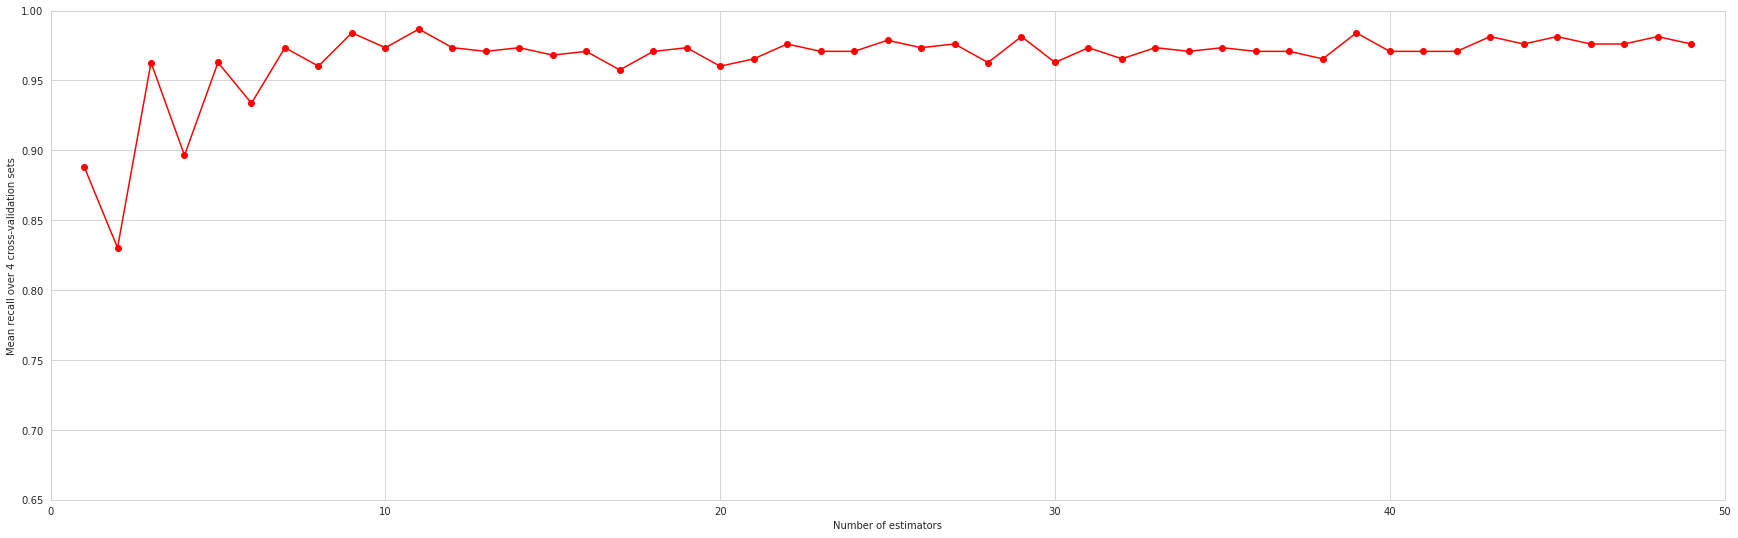

In [19]:
RF_best_estimators = grid_search_RF.best_params_['n_estimators']
print("For a Random Forest, the optimal number of estimators is "+str(RF_best_estimators))
RF_df = pd.DataFrame(grid_search_RF.cv_results_)
fig = plt.figure(figsize=(30,9))
plt.plot(RF_df['param_n_estimators'],RF_df['mean_test_score'],'r-o')
plt.xlim(0,50)
plt.ylim(0.65,1.0)
plt.xlabel('Number of estimators')
plt.ylabel('Mean recall over 4 cross-validation sets')

## Evaluation of the models on the test set 

In [20]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

KNN_final = grid_search_KNN.best_estimator_
KNN_final.fit(processed_data, y_train)

DT_final = grid_search_DT.best_estimator_
DT_final.fit(processed_data, y_train)

RF_final = grid_search_RF.best_estimator_
RF_final.fit(processed_data, y_train)

pipelines = [KNN_final, DT_final, RF_final]

best_recall = 0.0
best_classifier = 0.0
best_pipeline = ""

pipe_dict = {0:'k-Nearest Neighbours',1:'Decision Tree',2:'Random Forest'}

for i,model in enumerate(pipelines):
    X_test_trans = preprocess.transform(X_test)
    y_pred = model.predict(X_test_trans)
    print("{} test recall: {}".format(pipe_dict[i],recall_score(y_pred, y_test) ))
    print("{} test precision: {}".format(pipe_dict[i],precision_score(y_pred, y_test) ))
    print("{} test accuracy: {}".format(pipe_dict[i],accuracy_score(y_pred, y_test) ))
    if recall_score(y_pred,y_test)>best_recall:
        best_recall = recall_score(y_pred,y_test)
        best_pipeline = model 
        best_classifer = i

print("Classifier with best recall: {}".format(pipe_dict[best_classifier]))


k-Nearest Neighbours test recall: 1.0
k-Nearest Neighbours test precision: 0.9798657718120806
k-Nearest Neighbours test accuracy: 0.9902597402597403
Decision Tree test recall: 1.0
Decision Tree test precision: 0.959731543624161
Decision Tree test accuracy: 0.9805194805194806
Random Forest test recall: 1.0
Random Forest test precision: 0.9261744966442953
Random Forest test accuracy: 0.9642857142857143
Classifier with best recall: k-Nearest Neighbours
